In [1]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Cargo un dataset de prueba, en este caso ya normalizado de sklearn
dataset = load_diabetes()
print(dataset.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

Text(0.5, 1.0, 'disease progression in terms of bmi')

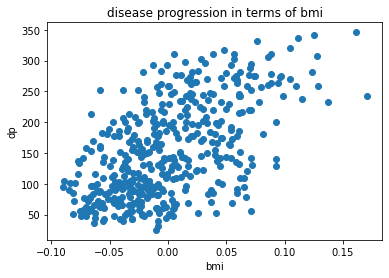

In [3]:
# Elijo una columna con forma idonea para hace regresion simple. 
selected_col = 2

X = dataset.data[:, selected_col]
Y = dataset.target

plt.scatter(X, Y)
plt.xlabel(dataset.feature_names[selected_col])
plt.ylabel('dp') # disease progression
plt.title('disease progression in terms of bmi')

In [4]:
# Divido X e Y en train (entrenar el modelo) y test (ponerlo a prueba).
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2)  
x_train.shape

(353,)

### <u>**Alternativa 1: Modelo de Regresion con Gradiente Descendiente</u>

Asumo que mi modelo va a ser una funcion lineal de la forma <b>"$f(x_i) = wx_i + b$"</b>, donde $w$ y $b$ son los parametros que busco optimizar para minimizar la diferencia entre mi modelo y los datos reales (medido a traves de la funcion de costo $C$). 

Defino a la funcion de costo (error medio cuadratico, total) segun MSE de la forma $C = \frac{1}{m}\sum{(f_{w,b}(x_i) - y_i)^2}$.

Determino la tasa de aprendizaje (l_rate) y la cantidad de iteraciones (n_epochs) para aplicar el algoritmo de gradiente descendiente.

> <u> Algoritmo. </u>
> 1. Seteo $w$, $b$, $lrate$ y $epochs$ a algun valor por defecto. 
> 2. for $n=0 \to epochs$ do:
> 3. $w = w - lrate * \frac{\partial C}{\partial w}$
> 4. $b = b - lrate * \frac{\partial C}{\partial b}$
> 5. end for~loop

- Se tiene en cuenta que $\frac{\partial C}{\partial w}$ y $\frac{\partial C}{\partial b}$ corresponden a la derivada parcial del <u> error total</u>, respecto a $w$ y $b$.

De esto puedo decir que:
- $\frac{\partial C}{\partial w} = \frac{2}{M} \sum{(wx_i+b-y_i)(x_i)}$, con $b$ como un valor constante fijado arbitrariamente y $w$ variable.
- $\frac{\partial C}{\partial b} = \frac{2}{M} \sum{(wx_i+b-y_i)}$, con $w$ como un valor constante fijado arbitrariamente y $b$ variable.

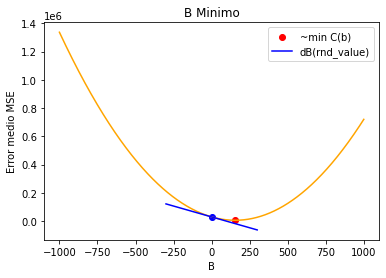

In [5]:
## Calculo cada error medio C en funcion de B, tomando como constante a W=1.
_fixed_w = 1
MIN, MAX = -1000, 1000
plt.plot(range(MIN, MAX), [(1/x_test.size)*sum([(_fixed_w*x_test[i]+b-y_test[i])**2 for i in range(y_test.size)])
                              for b in range(MIN, MAX)], color='orange')
plt.title('B Minimo')
plt.xlabel('B')
plt.ylabel('Error medio MSE')
VALUE = 152
C = lambda VALUE: (1/x_test.size)*sum([(_fixed_w*x_test[i]+VALUE-y_test[i])**2 for i in range(y_test.size)])
plt.scatter(VALUE, C(VALUE),
            color='red', label='~min C(b)')

# derivada de C respecto a B
def dB (b, X, Y):
    M = X.size
    return (2/M)*sum([_fixed_w*X[i]+b-Y[i] for i in range(M)])

CENTER = 0 # punto ejemplo al que se le aplica la derivada 
plt.plot(range(CENTER-300, CENTER+300), [dB(CENTER,x_test,y_test)*i+C(CENTER) for i in range(CENTER-300, CENTER+300)],
         label='dB(rnd_value)', color='blue')
plt.scatter(CENTER, C(CENTER), color='blue')

plt.legend()

0.7026823894625809


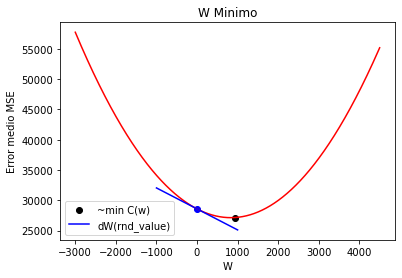

In [6]:
## Calculo cada error medio C en funcion de W, tomando como constante a B=1.
_fixed_b = 1
MIN, MAX = -3000, 4500
plt.plot(range(MIN, MAX), [(1/x_test.size)*sum([(w*x_test[i]+_fixed_b-y_test[i])**2 for i in range(y_test.size)])
                              for w in range(MIN, MAX)], color='red')
plt.title('W Minimo')
plt.xlabel('W')
plt.ylabel('Error medio MSE')
VALUE = 924
C = lambda VALUE: (1/x_test.size)*sum([(VALUE*x_test[i]+_fixed_b-y_test[i])**2 for i in range(y_test.size)])
plt.scatter(VALUE, C(VALUE),
            color='black', label='~min C(w)')

# derivada de C respecto a W
def dW (w, X, Y):
    M = X.size
    return (2/M)*sum([X[i]*(w*X[i]+_fixed_b-Y[i]) for i in range(M)])

CENTER = 0 # punto ejemplo al que se le aplica la derivada 
plt.plot(range(CENTER-1000, CENTER+1000), [dW(CENTER,x_test,y_test)*i+C(CENTER) for i in range(CENTER-1000, CENTER+1000)],
         label='dW(rnd_value)', color='blue')
plt.scatter(CENTER, C(CENTER), color='blue')
print (dW(1000,x_test,y_test))

plt.legend()

In [7]:
## modelo propio
class SimpleLinearModel ():
    def __init__ (self, l_rate=0.005):
        self.w = 1
        self.b = 1
        self.l_rate = l_rate
    
    def dW (self, w, X, Y, fixed_b=1): # dC/dW
        M = X.size
        return (2/M)*sum([X[i]*(w*X[i]+fixed_b-Y[i]) for i in range(M)])

    def dB (self, b, X, Y, fixed_w=1): # dC/dB
        M = X.size
        return (2/M)*sum([fixed_w*X[i]+b-Y[i] for i in range(M)])
    
    def predict(self, x):
        return self.w * x + self.b
    
    def fit(self, x_train, y_train, n_epochs=1000):
        for _ in range(n_epochs):
            last_w = self.w
            self.w -= self.l_rate * self.dW(self.w, x_train, y_train, fixed_b=self.b)
            self.b -= self.l_rate * self.dB(self.b, x_train, y_train, fixed_w=last_w)
            
        print ('*** modelo ajustado')
        plt.scatter(x_train, y_train, label='data')
        RANGO = [0.01*n-0.1 for n in range(20)] # grafico
        plt.plot(RANGO, [self.predict(i) for i in RANGO], color='red', label='model')
        plt.title('train_values')
        plt.legend()
    
    def test (self, x_test, y_test):
        y_preds = [self.predict(x) for x in x_test]
        ERROR = mean_squared_error(y_test, y_preds)
        plt.scatter(x_test, y_test, label='data')
        plt.plot(x_test, y_preds, label="model", color='red')
        plt.title('test_data w/ MSE')
        print ('Error MSE: ', ERROR)
        
    def coefs (self):
        print (self.w, self.b)

*** modelo ajustado
927.7864122132817 151.46049332489446


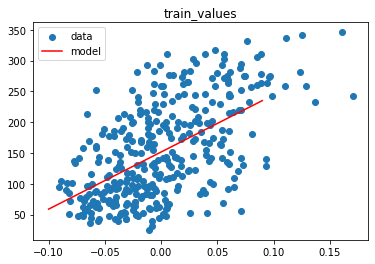

In [8]:
model = SimpleLinearModel(l_rate=0.5)
model.fit(x_train, y_train, n_epochs=1500)
model.coefs()

Error MSE:  3507.1682420687384


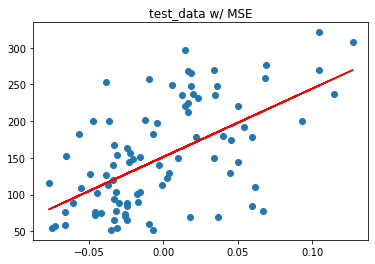

In [9]:
model.test(x_test, y_test)

957.7048549720996 151.45193651423688


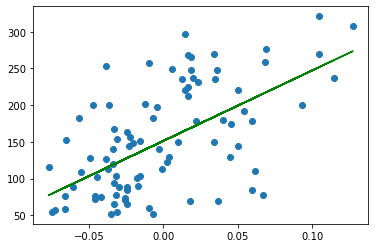

In [10]:
### modelo sklearn 
from sklearn import linear_model

sk_model = linear_model.LinearRegression()
sk_model.fit(x_train.reshape(-1, 1), y_train)
print (sk_model.coef_[0], sk_model.intercept_)

plt.plot(x_test, [sk_model.predict(x.reshape(-1, 1)) for x in x_test], color='green')
plt.scatter(x_test, y_test)

### <u>**Alternativa "2": Aproximar W y B con matriz de MSE </u>

Puedo armar una matriz A con todos los MSE (errores) respectivos a las filas W y las columnas B, con wmax y bmax fijados arbitrariamente. 
* Entonces, $A\in R^{wmax*bmax}$ tal que $A_{w,b}=\frac{1}{M}\sum^{m}_{i}{(wx_i+b-y_i)^2}$

* Y me queda una figura 3-dimensional de la forma $fig: (w, b, \frac{1}{M}\sum^{m}_{i}{(wx_i+b-y_i)^2}$)


Profundizando en el eje z, este puede ser reescrito de la forma
$z = w^2(\frac{\sum{x}^2}{M})-w(\frac{2\sum{xy}}{M})+b^2(\frac{1}{M})-b(\frac{2\sum{y}}{M})+bw(\frac{2\sum{x}}{M})+(\frac{\sum{y^2}}{M})$

O tambien: 

$z = w^2(A)-w(B)+b^2(C)-b(D)+bw(E)+(F)$

Siendo {A, B, ..., F} datos calculables a partir del x_train, y_train.

> Esta figura ($fig\in R^3$) tiene la forma: 
<img src='img/geogebra-export.png' width=400 height=100/>

- Encontrando el punto minimo de MSE se hallan los valores optimos de W y B. Esto se puede hacer con gradiente descendiente o directamente mediante la libreria numpy con <b>np.argmin(MSE_MATRIX,axis=Q,out=None)</b>, para cada respectivo eje Q:{0, 1}.

In [11]:
## ELijo wmax y bmax arbitrariamente.
w_max = 1000
b_max = 200

# Inicializo la matriz M en todos ceros
M = x_test.size
MSE_MATRIX = np.zeros((w_max, b_max)) # E R^(w_max x b_max)

# Agrego cada valor de MSE en cada punto
for w in range(w_max):
    for b in range(b_max):
        MSE_MATRIX[w][b] = (1/M) * sum([(w*x_test[i]+b-y_test[i])**2 for i in range(M)])

In [12]:
best_coefs = (np.argmin(MSE_MATRIX,axis=0,out=None)[-1],   
              np.argmin(MSE_MATRIX,axis=1,out=None)[-1]) 
best_coefs

(939, 155)

In [13]:
A = (1/M)*sum([x for x in x_test])**2
B = (2/M)*sum([x+y_test[i] for i, x in enumerate(x_test)])
C = 1/M
D = (2/M)*sum([y for y in y_test])
E = (2/M)*sum([x for x in x_test])
F = (1/M)*sum([y for y in y_test])**2

print ('A', A)
print ('B', B)
print ('C', C)
print ('D', D)
print ('E', E)
print ('F', F)

print ('\nfig: (w; b; Aw^2 - Bw + Cb^2 - Db -Ewb + F)')

A 0.000113998425389435
B 307.5033544570981
C 0.011235955056179775
D 307.50561797752806
E -0.0022635204299064366
F 2103953.438202247

fig: (w; b; Aw^2 - Bw + Cb^2 - Db -Ewb + F)
